# SNP analysis of different miRNA regions

* Both the dbSNP version (filtered for entries with gnomAD frequency information) and MirGeneDB are based on the human genome version GRCh38


## Extract the genomic position of all miRNAs and their different regions

In [1]:
import json
import numpy as np

###################################################################################################################
mirna_gff = '/home/felixl/PycharmProjects/human_miRNA_evol/data/raw/mirgenedb_hsa.gff'
outfile = '/home/felixl/PycharmProjects/human_miRNA_evol/data/processed/SNPs/mirna_regions.json'
###################################################################################################################


def read_mirna_gff(path, flanklength=30):
    """
    returns:
        pos_dict = {chromosome: {'downstream': [(start, end), ...], 'pre_mirna': [], 'mature': [], 'hairpin': [], 'star': [], 'upstream': []}}
    """
    mirna_out_dict = {}
    region_dict = {}
    with open(path, 'r') as fh:
        for line in fh:
            if not line.startswith('#'):
                chrom, d1, typ, start, end, d2, strand, d3, info = line.strip().split()
                if typ == 'pre_miRNA':
                    start = int(start)
                    end = int(end)
                    mirna = info.split(';')[0].replace('ID=', '')
                    nextl = next(fh).strip().split(';')[0]
                    if nextl.endswith('*'):
                        star_start, star_end = map(int, nextl.split()[3:5])
                        matl = next(fh)
                        mat_start, mat_end = map(int, matl.split()[3:5])
                    elif nextl.endswith('_pre'):
                        raise ValueError('File is not consistently formatted')
                    else:
                        mat_start, mat_end = map(int, nextl.split()[3:5])
                        starl = next(fh)
                        star_start, star_end = map(int, starl.split()[3:5])

                    downstream = (start - flanklength - 1, start -1)
                    upstream = (end + 1, end + 1 + flanklength)
                    pre_mirna = (start, end)
                    mature = (mat_start, mat_end)
                    star = (star_start, star_end)
                    if star_start >= mat_start:
                        # 5p-mature miRNA
                        hairpin_start = mat_end + 1
                        hairpin_end = star_start - 1
                    else:
                        # 3p-mature miRNA
                        hairpin_start = star_end + 1
                        hairpin_end = mat_start - 1
                    hairpin = (hairpin_start, hairpin_end)
                    
                    if not chrom in region_dict:
                        region_dict[chrom] = {'downstream': [], 'pre_mirna': [], 'mature': [], 'hairpin': [], 'star': [], 'upstream': []}
                        
                    region_dict[chrom]['downstream'].append(downstream)
                    region_dict[chrom]['pre_mirna'].append(pre_mirna)
                    region_dict[chrom]['mature'].append(mature)
                    region_dict[chrom]['hairpin'].append(hairpin)
                    region_dict[chrom]['star'].append(star)
                    region_dict[chrom]['upstream'].append(upstream)
        return region_dict

mirna_dict = read_mirna_gff(mirna_gff)
with open(outfile, 'w') as of:
    json.dump(mirna_dict, of)

## Find CDS and lncRNA regions

* Only include genes on chromosomes (id starts with NC_)

In [2]:
import json

###################################################################################################################
gff_path = '/home/felixl/PycharmProjects/human_miRNA_evol/data/raw/hsa_refseq_genomic.gff'
report_path = '/home/felixl/PycharmProjects/human_miRNA_evol/data/raw/hsa_refseq_assemblyreport.txt'

outfile = '/home/felixl/PycharmProjects/human_miRNA_evol/data/processed/SNPs/other_regions.json'
#########################################################################################################


def make_chrom_map(path):
    map_dict = {}
    with open(path, 'r') as fh:
        for line in fh:
            if not line.startswith('#'):
                data = line.strip().split()
                nc = data[6]
                num = data[-1]
                map_dict[nc] = num
    return map_dict
                

def read_refseq_gff(path, chrommap):
    """
    returns:
        pos_dict = {chromosome: {'protein_coding': [(start, end), ...], 'lncRNA': [],}}
    """
    type_list = ['protein_coding', 'lncRNA']
    
    
    with open(path, 'r') as fh:
        pos_dict = {}
        for line in fh:
            if not line.startswith('#'):
                data = line.strip().split()
                nc_chrom = data[0]
                if not nc_chrom.startswith('NC'):    # skip all entries not from canonical chromosomes
                        continue
                chrom = chrommap[nc_chrom]
                if not chrom in pos_dict:
                    pos_dict[chrom] = {}
                if 'gene_biotype=' not in data[-1]:
                    continue
                biotype = data[-1].split('gene_biotype=')[1].split(';')[0]
                
                if biotype in type_list:
                    if biotype not in pos_dict[chrom]:    # initialize dict
                        pos_dict[chrom][biotype] = []
                    start, end = map(int, data[3:5])
                    pos_dict[chrom][biotype].append((start, end))
    return pos_dict



                    
nc_2_num = make_chrom_map(report_path)
region_dict = read_refseq_gff(gff_path, nc_2_num)
with open(outfile, 'w') as of:
    json.dump(region_dict, of)

## Concatenate the miRNA region and the protein-coding/lncRNA dicts

In [3]:
import json

###################################################################################################################
protpath = '/home/felixl/PycharmProjects/human_miRNA_evol/data/processed/SNPs/other_regions.json'
mirpath = '/home/felixl/PycharmProjects/human_miRNA_evol/data/processed/SNPs/mirna_regions.json'

outpath = '/home/felixl/PycharmProjects/human_miRNA_evol/data/processed/SNPs/all_regions.json'
#########################################################################################################


def read_json(path):
    with open(path, 'r') as fh:
        out_dict = json.load(fh)
    return out_dict


protdict = read_json(protpath)
mirdict = read_json(mirpath)
alldict = protdict

for chrom in mirdict:
    if chrom == 'chrM':
        continue
    alldict[chrom].update(mirdict[chrom])


with open(outpath, 'w') as of:
    json.dump(alldict, of)

print('# done')

print(protdict.keys())

# done
dict_keys(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM'])


## Identify SNPs and their frequency for each region

In [4]:
"""
loads:
    pos_dict = {chromosome: {'downstream': [(start, end), ...], 'pre_mirna': [], 'mature': [], 'hairpin': [], 'star': [], 'upstream': []}}

returns: 
    snp_dic = {'downstream': {'length': 150, 'numsnps': 15}}, 'pre_mirna': ...}
    mafs_ic = {'downstream': ['3.186e-05', '6.373e-05', '3.185e-05', '3.185e-05'], 'pre_mirna':...}
"""

import json

###################################################################################################################
chrom_json_dir = '/share/project/felixl/dbSNP/chromwise_dbSNP'
position_path = '/home/felixl/PycharmProjects/human_miRNA_evol/data/processed/SNPs/all_regions.json'

outsnps = '/home/felixl/PycharmProjects/human_miRNA_evol/data/processed/SNPs/no_snps_per_region.json'
outmafs = '/home/felixl/PycharmProjects/human_miRNA_evol/data/processed/SNPs/mafs_per_region.json'
###################################################################################################################


def read_json(path):
    with open(path, 'r') as fh:
        out_dict = json.load(fh)
    return out_dict


def find_SNPs(start, end, chromsnps):
    """
    params:
        chromsnps: dict('chromosome_position': 'gnomAD_MAF')  
    """
    mafs = []
    for loc in range(start, end+1):
        try:
            mafs.append(chromsnps[str(loc)])
        except KeyError:
            continue
    return mafs


def list2dict(dic, key, ilist):
    if not key in dic:
        dic[key] = []
    dic[key].extend(ilist)
    return dic


def count_snps(start, end, mafs, dic, reg):
    if not reg in dic:
        dic[reg] = {'length': 0, 'numsnps': 0}
    dic[reg]['length'] += end - start
    dic[reg]['numsnps'] += len(mafs)

    
def save_json(path, variable):
    with open(path, 'w') as of:
        json.dump(variable, of)
    


mafs_dic = {}
snp_out = {}
pos_dic = read_json(position_path)
for chrom in pos_dic:
    chrompath = f'{chrom_json_dir}/{chrom}.json'
    with open(chrompath, 'r') as ch:
        snp_db = json.load(ch)

        for region in pos_dic[chrom]:
            for element in pos_dic[chrom][region]:
                start, end = element
                maf_list = find_SNPs(start, end, snp_db)
                count_snps(start, end, maf_list, snp_out, region)
                list2dict(mafs_dic, region, maf_list)
                

save_json(outsnps, snp_out)
save_json(outmafs, mafs_dic)
print('done')


KeyboardInterrupt: 

## 

## Visualize SNP density

,length,numsnps,ratio
lncRNA,435312734,29055815,66.746991
protein_coding,1263546390,84370056,66.772425
downstream,16650,1195,71.771772
mature,11836,561,47.397770
hairpin,8349,486,58.210564
star,11809,684,57.921924
upstream,16650,1291,77.537538


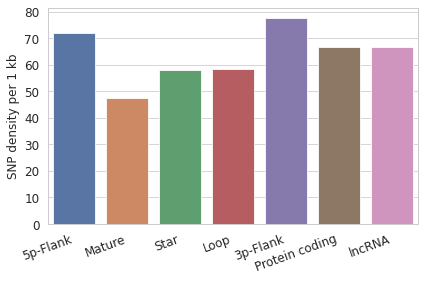

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

###################################################################################################################
snps = '/home/felixl/PycharmProjects/human_miRNA_evol/data/processed/SNPs/no_snps_per_region.json'

figout = '/home/felixl/PycharmProjects/human_miRNA_evol/figures/snp_density_mirnas.png'
###################################################################################################################

def load_snps(path):
    with open(path, 'r') as fh:
        tmpdic = json.load(fh)
    df = pd.DataFrame.from_dict(tmpdic, orient='index')
    df = df.drop(index='pre_mirna')
    df['ratio'] = df['numsnps']/df['length'] * 1000
    return df
    
    
snpdf = load_snps(snps)
display(snpdf)

sns.set_style('whitegrid')
# sns.set_theme('paper')
order = ['downstream', 'mature', 'star', 'hairpin', 'upstream', 'protein_coding', 'lncRNA']
ax = sns.barplot(data=snpdf, x=snpdf.index, y='ratio', order=order)
plt.ylabel('SNP density per 1 kb', size=12)    

xticks = ['5p-Flank', 'Mature', 'Star', 'Loop', '3p-Flank', 'Protein coding', 'lncRNA']
ax.set_xticklabels(xticks,rotation = 20, ha='right')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()

plt.savefig(figout, dpi=600)
plt.savefig(figout.replace('.png', '.svg'))

## Visualize MAF distribution

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

###################################################################################################################
maf_path = '/home/felixl/PycharmProjects/human_miRNA_evol/data/processed/SNPs/mafs_per_region.json'
###################################################################################################################

def categorize_mafs(maf_dict):
    common = 0
    uncommon = 0
    rare = 0
    ultra_rare = 0
    no_data = 0
    num_snps = len(maf_dict)
    
    for maf in maf_dict:
        try:
            maf = float(maf)
        except ValueError:
            try:
                maf = float(maf.split(';')[0])
            except:
                no_data += 1
                continue
        if maf >= 0.05:
            common += 1
        elif maf < 0.05 and maf >= 0.01:
            uncommon += 1
        elif maf < 0.01 and maf >= 0.0001:
            rare += 1
        elif maf < 0.0001:
            ultra_rare += 1
    return map(lambda x: x/num_snps, [common, uncommon, rare, ultra_rare, no_data])


def load_mafs(path):
    df_dict = {'count': [], 'rarity': [], 'region': []}
    with open(path, 'r') as fh:
        m_dict = json.load(fh)
        for region in m_dict:
            if region == 'pre_mirna':
                continue
            
            common, uncommon, rare, ultra_rare, no_data = categorize_mafs(m_dict[region])
            catlist = ['common', 'uncommon', 'rare', 'ultra_rare', 'no_data']
            
            df_dict['region'].append(region)
            df_dict['count'].append(common)
            df_dict['rarity'].append('common')
            
            df_dict['region'].append(region)
            df_dict['count'].append(uncommon)
            df_dict['rarity'].append('uncommon')
            
            df_dict['region'].append(region)
            df_dict['count'].append(rare)
            df_dict['rarity'].append('rare')
            
            df_dict['region'].append(region)
            df_dict['count'].append(ultra_rare)
            df_dict['rarity'].append('ultra_rare')
            
            df_dict['region'].append(region)
            df_dict['count'].append(no_data)
            df_dict['rarity'].append('no_data')
            
    df = pd.DataFrame.from_dict(df_dict)
    return df


                                         
mafdf = load_mafs(maf_path)

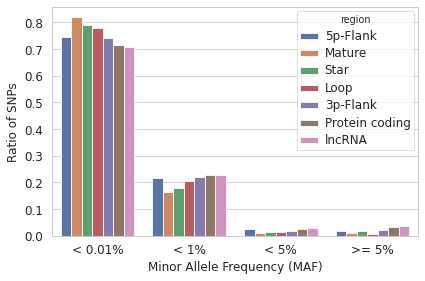

In [5]:
figout = '/home/felixl/PycharmProjects/human_miRNA_evol/figures/MAFs_all_regions.png'

# only works with cell above
mafdf = mafdf[mafdf['rarity'] != 'no_data']

df_names = ['downstream', 'mature', 'star', 'hairpin', 'upstream', 'protein_coding', 'lncRNA']
nice_names = ['5p-Flank', 'Mature', 'Star', 'Loop', '3p-Flank', 'Protein coding', 'lncRNA']
order = ['ultra_rare', 'rare', 'uncommon', 'common']
xticks = ['< 0.01%', '< 1%', '< 5%', '>= 5%']

for tup in zip(df_names, nice_names):
    mafdf = mafdf.replace(tup[0], tup[1])

sns.set_style('whitegrid')
ax = sns.barplot(data=mafdf, x='rarity', y='count', hue='region', order=order, hue_order=nice_names)

ax.set_xticklabels(xticks)#,rotation = 20, ha='right')
plt.ylabel('Ratio of SNPs', size=12)
plt.xlabel('Minor Allele Frequency (MAF)', size=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='12')
plt.tight_layout()
plt.savefig(figout, dpi=600)
plt.savefig(figout.replace('.png', '.svg'))

## Legacy 

In [ ]:
mafs = []
for loc in range(start, end+1):
    try:
        mafs.append(chr_dict[str(loc)])
    except KeyError:
        continue
# print(mafs)
lnc_dict[chrom][id]['no_snps'] = len(mafs)
lnc_dict[chrom][id]['mafs'] = mafs

def read_mirnas(path, map_p):
    """
    Read mirnas from TSV file and return a dictionary like {chromosome: {mirna: (start, end)}
    """
    chrom_dict = read_chrom_map(map_p)
    mi_di = {}
    with open(path, 'r') as fh:
        for line in fh:
            mirna, nc_chrom, start, end, strand, pre, mat = line.strip().split()
            start
            chrom = chrom_dict[nc_chrom]
            if chrom not in mi_di:
                mi_di[chrom] = {}
            mi_di[chrom][mirna] = (int(start), int(end))
    return mi_di


def read_chrom_map(path):
    chrom_map = {}
    with open(path, 'r') as fh:
        for line in fh:
            num, nc = line.strip().split()
            chrom_map[nc] = num
    return chrom_map


### snps

sns.set_style('whitegrid')
order = ['downstream', 'mature', 'star', 'hairpin', 'upstream', 'protein_coding', 'lncRNA']
ax = sns.barplot(data=snpdf, x=snpdf.index, y='ratio', order=order)
plt.ylabel('SNP density per 1 kb')    

xticks = ['5p-Flank', 'Mature', 'Star', 'Hairpin', '3p-Flank', 'Protein coding', 'lncRNA']
ax.set_xticklabels(xticks,rotation = 20, ha='right')


### maf
mafdf = mafdf[mafdf['rarity'] != 'no_data']

df_names = ['downstream', 'mature', 'star', 'hairpin', 'upstream', 'protein_coding', 'lncRNA']
nice_names = ['5p-Flank', 'Mature', 'Star', 'Hairpin', '3p-Flank', 'Protein coding', 'lncRNA']
order = ['ultra_rare', 'rare', 'uncommon', 'common']
xticks = ['< 0.01%', '< 1%', '< 5%', '>= 5%']

for tup in zip(df_names, nice_names):
    mafdf = mafdf.replace(tup[0], tup[1])

sns.set_style('whitegrid')
ax = sns.barplot(data=mafdf, x='rarity', y='count', hue='region', order=order, hue_order=nice_names)

ax.set_xticklabels(xticks)#,rotation = 20, ha='right')
plt.ylabel('Ratio of SNPs')
plt.xlabel('Minor Allele Frequency (MAF)')